### 앙상블: Boosting

- 다양한 모델을 결합하여 예측 성능을 향상시키는 기법
    - 깊이가 얕은 결정트리를 사용해 이전 트리의 오차를 보정하는 방식
    - 순차적으로 경사하강법을 사용해 이전 트리의 오차를 줄여나감
        - 분류 모델에서는 손실함수 Logloss를 사용해 오차 줄임
        - 회귀 모델에서는 손실함수 MSE 사용해 오차 줄임
    - Boosting 게열은 일반적으로 결정트리 개수를 늘려도 과적합에 강함
    - 대표적인 알고리즘(모델): GradientBoosting, HistGradientBoosting, XGBoost(DMLC), LightGBM(MS), CatBoost
    *DMLC: XGBoost 지속적인 연구, 개발 중
    *MS: 마이크로소프트 사에서 LightGBM을 내놓음

### GradientBoosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeRegressor

In [13]:
class SimpleGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate = .2, max_depth=3):
        # 하이퍼 파라미터 등 값을 받아 객체 변수로 저장하기 위해 생성자에서 저장
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.initial_log_odds = 0   # 초기 예측값 설정
        self.trees = []             # 해당 모델이 사용할 트리 객체를 저장해두기 위한 변수 (estimator 모음 배열)
        

    def log_odds(self, p):
        # 0~1값만 가지는 확률 p에 대해 로그함수 취해 차이 극대화 (확률->로짓 변환)
        return np.log(p/(1-p))
        # x=0, x=1 에서 각각 y가 -무한대, 무한대로 발산

    def sigmoid(self, z):
        # 시그모이드 함수 -> 0~1 변환
        return 1/(1+np.exp(-z))
    
    def fit(self, X, y):
        # 훈련 등 fit() 함수
        y_mean = np.mean(y)
        # 초기값을 label 데이터의 평균으로 계산.
        # 이진 분류 문제이므로 y는 0, 1 뿐일 것. -> 결국 y_mean은 1의 비율이 될 것 -> 0~1 값이므로 log_odds 메서드 사용 가능

        self.initial_log_odds = self.log_odds(y_mean)
        # 큰 수로 변환하기 위함
        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=np.float64)
        # y의 shape만큼 initial_log_odds 값 들은 확률 행렬 생성
        # -- 초깃값 지정

        
        for _ in range(self.n_estimators):
            y_pred_proba = self.sigmoid(y_pred_log_odds)
            # 현재 예측된 확률값을 sigmoid 취해 변수에 저장(0~1 사이로 변환)

            residual = y-y_pred_proba
            # 잔차 계산

            tree=DecisionTreeRegressor(max_depth=self.max_depth)
            # 잔차는 연속적인 값이기 때문에 분류 결정트리가 아닌 회귀 결정트리 객체 생성. 이 트리로 학습을 반복하며 잔차를 줄일 것
            tree.fit(X, residual)
            # 잔차를 label 데이터로 전달
            self.trees.append(tree)
            # 호출한 트리 객체 저장
            
            y_pred_log_odds += self.learning_rate * tree.predict(X)
            # 학습률*예측값을 다시 행렬에 저장


    def predict(self, X):
        # 특성 예측 함수
        return (self.predict_proba(X) >= 0.5).astype(int)
        # 확률값이 0.5 이상이면 True -> 1 반환
    
    def predict_proba(self, X):
        # 특성 예측 확률 반환 함수
        y_pred_log_odds = np.full(X.shape[0], self.initial_log_odds)
        # 초기화
    
        for tree in self.trees:
            y_pred_log_odds += self.learning_rate * tree.predict(X)
        # fit()에서 같이 저장할 순 없나? 다시 tree객체를 꺼내서 ... 해야되나?
        # 아마 따로 확인해보려고...?
        
        return self.sigmoid(y_pred_log_odds)
        # tree만큼 predict 후 저장된 확률을 반환


In [3]:
# Simple Gradient Boosting Classifier()로 유방암 데이터 예측
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score # classifier이므로 정확도 평가

In [ ]:
# 데이터 로드
data = load_breast_cancer()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# 모델 생성
simple_gb_clf = SimpleGradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3)

simple_gb_clf.fit(X_train, y_train)

y_pred_train = simple_gb_clf.predict(X_train)
y_pred_test = simple_gb_clf.predict(X_test)

# print(y_pred_train, y_pred_test)

print(f'학습 정확도: {accuracy_score(y_train, y_pred_train)}\n평가 정확도: {accuracy_score(y_test, y_pred_test)}')
# 학습 정확도: 0.9507042253521126
# 평가 정확도: 0.9370629370629371

학습 정확도: 0.9507042253521126
평가 정확도: 0.9370629370629371


(실습-완료)(숙제) XGBoost

##### 와인데이터셋 이진 분류

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
# 1. 데이터 로드
wine_data = pd.read_csv('./data/wine_simple.csv')

# 2. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(wine_data.drop('class', axis=1), wine_data['class'], random_state=0)

# 3. RandomForestClassifier 모델 학습
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3
)
rf_clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# 4. 예측
rf_pred = rf_clf.predict(X_test)

# 5. 정확도 출력
rf_clf.score(X_train, y_train), rf_clf.score(X_test, y_test)

(0.8296387520525451, 0.832)

In [22]:
list(wine_data.columns)[:3]

['alcohol', 'sugar', 'pH']

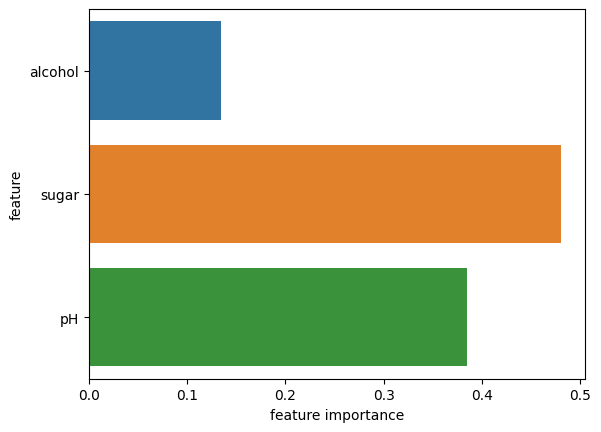

In [25]:
# 6. 특성 중요도 시각화(feature importances)
sns.barplot(x = rf_clf.feature_importances_,
            y = list(wine_data.columns)[:3],
            hue=list(wine_data.columns)[:3])
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()

(실습)
##### 인간행동인식 다중 분류

https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones 

사용자 행동 target class
- WALKING
- WALKING_UPSTAIRS
- WALKING_DOWNSTAIRS
- SITTING
- STANDING
- LAYING

**HAR 특성 설명**

| **특성 유형**             | **설명**                                                                                                                                     |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **Mean와 Std**            | 'tBodyAcc-mean()-X', 'tBodyAcc-std()-Y'와 같은 특성은 시간 도메인에서의 신체 가속도에 대한 평균 및 표준편차 값 ('X', 'Y', 'Z'는 축을 의미) |
| **주파수 도메인 특징**     | 이름에 'f'로 시작하는 특성은 주파수 도메인에서 계산된 값 (예를 들어 'fBodyAcc-meanFreq()-X'는 신체 가속도 센서의 X축에서의 평균 주파수 값)    |
| **가속도와 자이로스코프 데이터** | 'tBodyAcc', 'tGravityAcc', 'tBodyGyro' 등의 특성은 신체 가속도, 중력 가속도, 자이로스코프 데이터                                                  |
| **Jerk 신호**             | 'tBodyAccJerk-mean()-X'와 같은 특성은 가속도의 변화율 (활동 간의 차이를 분류하는 데 중요한 역할)                                          |
| **Magnitude(크기)**       | 'tBodyAccMag-mean()', 'tGravityAccMag-std()'와 같은 특성은 특정 축 방향의 가속도 또는 자이로스코프 값을 합친 크기                                             |
| **FFT 변환 기반 특징**    | 주파수 도메인에서의 데이터 특성들은 Fourier 변환을 통해 얻어짐 (예를 들어, 'fBodyAccMag-mean()'은 주파수 도메인에서 가속도의 크기의 평균값)                  |
| **Angle(각도)**           | 'angle(X,gravityMean)'과 같은 특성은 특정 축과 중력 벡터 간의 각도 (중력과의 상대적인 위치 나타냄)                                                    |
| **레이블**                | 'Activity' 컬럼에는 각 행의 활동 레이블이 포함 (걷기, 계단 오르기, 계단 내리기, 앉기, 서기, 눕기 등의 활동 종류 있음)                                          |


In [33]:
# 1. 데이터 로드
train = pd.read_csv('./data/har_train.csv')
test = pd.read_csv('./data/har_test.csv')

print(train.shape, test.shape)
# (7352, 563) (2947, 563)

(7352, 563) (2947, 563)


In [34]:
# 2. 데이터 분리
X_train = train.drop('Activity', axis=1)
y_train = train['Activity']

X_test = test.drop('Activity', axis=1)
y_test = test['Activity']

In [ ]:
# 3. 라벨 인코딩(Activity 숫자로 변환)
from sklearn.preprocessing import LabelEncoder



# 4. 데이터 정규화

# 5. RandomForestClassifier 모델 학습

# 6. 모델 예측

# 7. 평가 (정확도) acurray score

# 8. 중요도 상위 20개의 특성 시각화

### GradientBoosting 분류기

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df

gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3
)
# gradient boosting 객체 생성

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1), df['target'], random_state=0)

gb_clf.fit(X_train, y_train)

y_pred_train = gb_clf.predict(X_train)
y_pred_test = gb_clf.predict(X_test)

print(f'학습 정확도: {accuracy_score(y_train, y_pred_train)}\n평가 정확도: {accuracy_score(y_test, y_pred_test)}')
# 학습 정확도: 0.9882629107981221
# 평가 정확도: 0.958041958041958
# 위의 Simple GradientBoosting보다 다소 높아짐

학습 정확도: 0.9882629107981221
평가 정확도: 0.958041958041958


### HistGradientBoosting
- 고성능 GradientBoosting 모델로 대규모 데이터셋 처리에 적합
- Histogram 기반으로 최대 256개의 구간으로 나누어 처리 병합하는 방식
  (한 구간은 무조건 결측치 구간)
- 결측치가 있어도 전처리가 필요 없음(하나의 범주로 판단해 처리하기 때문에 결측치 영향x)
- LightGBM의 영향을 받아 만들어진 scikit-learn의 모델

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    max_bins=255, # 기본값 255. [2, 255]만 가능
    # 만약 10 지정시 결측치 구간 +1 되어 11개의 구간으로 처리

    early_stopping=True,
    n_iter_no_change=5
    # 5번 이상 성능 향상에 변화가 없으면 학습 조기 종료. 횟수 기본값: 10
)

hist_gb_clf.fit(X_train, y_train)

y_pred_train = hist_gb_clf.predict(X_train)
y_pred_test = hist_gb_clf.predict(X_test)

print(f'학습 정확도: {accuracy_score(y_train, y_pred_train)}\n평가 정확도: {accuracy_score(y_test, y_pred_test)}')
# 학습 정확도: 1.0
# 평가 정확도: 0.972027972027972
# max_bins=200 정도가 제일 높음

# 조기 종료 속성 넣었을 때 학습 정확도: 0.9906103286384976, 평가 정확도: 0.986013986013986


학습 정확도: 0.9906103286384976
평가 정확도: 0.986013986013986


In [ ]:
# 특성 중요도 추출
# 결정 트리는 만들어낸 규칙으로, 지니 불순도 or MSE 감소 최적화로 분류하며 이때 특성 중요도도 결정됨)
from sklearn.inspection import permutation_importance

result = permutation_importance(
    hist_gb_clf,
    X_train,
    y_train,
    n_repeats=5,
    random_state=0
)
# 계산법
# 피쳐 데이터 선택 -> 값 무작위 섞음(순서 바뀜) -> hist_gb_clf에 줘서 성능이 얼마나 하락하는지 봄
# 다섯 번 반복

result
result.keys() # ['importances_mean', 'importances_std', 'importances']
              # 중요도 평균값(30개), 중요도 표준편차(30개), 특성 중요도 (30x5개. repeats=5이므로)

result.importances

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00234742, 0.00469484, 0.00469484, 0.00469484, 0.00469484],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00234742, 0.00234742, 0.00469484, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00938967, 0.00704225, 0.00704225, 0.01173709, 0.01173709],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00234742, 0.        , 0.00469484, 0.        , 0.        ],
       [0.00469484, 0.00234742, 0.00234742, 0.00469484, 0.00234742],
       [0.        , 0.        , 0.

##### 회귀 모델

`sklearn.datasets.load_diabetes` 데이터셋
- 당뇨병 환자의 진단 자료를 바탕으로 만들어진 회귀용 데이터셋

**데이터셋 설명:**
- **목적**: 당뇨병 진행 정도(1년 후)를 예측
- **데이터 수**: 442개의 샘플
- **특성 수**: 10개의 특성 (10개의 입력 변수)
- **타겟**: 연속형 값, 당뇨병의 1년 후 진행 상황을 나타냄

**특성 설명:**
데이터셋의 각 특성(피처)은 환자의 다양한 생체 정보

1. **age**: 나이 (Age)
2. **sex**: 성별 (Sex)
3. **bmi**: 체질량 지수 (Body Mass Index)
4. **bp**: 평균 혈압 (Average Blood Pressure)
5. **s1**: 혈청 내 TC (Total Cholesterol)
6. **s2**: 혈청 내 LDL (Low-Density Lipoproteins)
7. **s3**: 혈청 내 HDL (High-Density Lipoproteins)
8. **s4**: 혈청 내 TCH (Total Cholesterol / HDL)
9. **s5**: 혈청 내 LTG (Log of Serum Triglycerides)
10. **s6**: 혈당 수치 (Blood Sugar Level)

**데이터 구조:**
- **입력 데이터 (data)**: (442, 10) 크기의 NumPy 배열
- **타겟 데이터 (target)**: (442,) 크기의 NumPy 배열로, 각 샘플의 타겟 값(연속형 값)을 포함

In [193]:
from sklearn.datasets import load_diabetes # 당뇨병 데이터

# 1. 데이터 로드
d_data = load_diabetes()
X = d_data.data
y = d_data.target

# 2. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [204]:
# 3. HistGradientBoostingRecgressor 모델 생성 및 학습
hist_gb_reg = HistGradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    max_bins=70,
    #early_stopping=True,
    #n_iter_no_change=5
    l2_regularization=.5,
    min_samples_leaf=5
)
# --> 교차검증으로 score 높게 나오는 하이퍼 파라미터 찾기 가능

# hist_gb_reg=HistGradientBoostingRegressor(
#     l2_regularization= 0.3,
#     learning_rate= 0.1,
#     max_bins= 150,
#     max_depth= 3,
#     max_iter= 50,
#     min_samples_leaf= 20
# )

hist_gb_reg.fit(X_train, y_train)

# 4. 예측, MSE, R2 score 계산
y_pred_train = hist_gb_reg.predict(X_train)
y_pred_test = hist_gb_reg.predict(X_test)

print(f'학습 정확도 MSE: {mean_squared_error(y_train, y_pred_train)}, R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 정확도 MSE: {mean_squared_error(y_test, y_pred_test)}, R2: {r2_score(y_test, y_pred_test)}')


학습 정확도 MSE: 3067.2180407098135, R2: 0.48530324133226554
평가 정확도 MSE: 3302.585834614791, R2: 0.43322176192152706


In [ ]:
# 교차 검증
# train 데이터 내에서 데이터 분할해 하나씩 검증 dataset으로 삼으며 훈련 진행

from sklearn.model_selection import GridSearchCV

hist_gb_reg = HistGradientBoostingRegressor(random_state=0)
# estimator에 전달한 객체 생성

param_grid = {
    'max_iter':[50, 100, 200],
    'max_depth':[3, 5, 7],
    'learning_rate':[0.01, 0.1, 1],
    'min_samples_leaf':[5, 10, 20],
    'l2_regularization': [0.0, 0.3, 0.8],
    'max_bins':[40, 150, 250]
}
# 파라미터를 dictionary 형태로 저장
# 5분 44초 돌음;

grid_search = GridSearchCV(hist_gb_reg, param_grid, cv=3, scoring='neg_mean_squared_error')
   # estimator, param_grid: 두 속성은 최적화된 성능값을 찾아주는 역할을 하게 됨
   # param_grid의 모든 조합마다 해봄. 3**6 = 729번 객체 출력하고 성능 평가
   # Cross Valination(cv): 교차검증을 세 번 할 것. 즉, train데이터를 세 등분해서 한 박스씩 검증 데이터로 삼을 것
   # scoring: MSE의 최솟값(neg) 기준
grid_search.fit(X_train, y_train)

grid_search.best_params_ # 전달된 하이퍼 파라미터값 조합 중 최고의 성능일 때 파라미터를 출력

# 최적의 파라미터로 다시 수행했을 때:
# 학습 정확도 MSE: 1838.3700038572474, R2: 0.6915109817238991
# 평가 정확도 MSE: 2547.5996232155635, R2: 0.5627898567717572

{'l2_regularization': 0.3,
 'learning_rate': 0.1,
 'max_bins': 150,
 'max_depth': 3,
 'max_iter': 50,
 'min_samples_leaf': 20}

In [ ]:
best_hist_gb_reg = grid_search.best_estimator_
# 최고 성능일 때 파라미터 조합으로 학습된 모델 객체

y_pred_train = best_hist_gb_reg.predict(X_train)
y_pred_test = best_hist_gb_reg.predict(X_test)

print(f'학습 정확도 MSE: {mean_squared_error(y_train, y_pred_train)}, R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 정확도 MSE: {mean_squared_error(y_test, y_pred_test)}, R2: {r2_score(y_test, y_pred_test)}')

학습 정확도 MSE: 1838.3700038572474, R2: 0.6915109817238991
평가 정확도 MSE: 2547.5996232155635, R2: 0.5627898567717572
